In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import pandas as pd
import phylovelo as pv
from tqdm.autonotebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [5]:
data_path = '/data3/wangkun/phylovelo_datasets/atlas/'

In [6]:
meta = pd.read_csv(data_path+'meta.csv')
meta = meta.replace('3.54E+25', '345000')
meta = meta.replace('5579', '005579')

/tmp/ipykernel_112382/2769237700.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(data_path+'meta.csv')


In [7]:
adata = sc.read(data_path+'raw_counts.mtx')
genes = pd.read_csv(data_path+'genes.tsv', delimiter='\t',header=None)

In [8]:
samples = np.random.choice(meta.index[(~np.isin(meta.stage, ['mixed_gastrulation']))&(~meta.colour.isna())&(~np.isnan(meta.umapX))&(~np.isin(meta.celltype, ['ExE ectoderm','Parietal endoderm', 'ExE endoderm']))], 10000, replace=False)
time = np.array([float(i[1:]) for i in meta.loc[samples].stage])

In [9]:
count = adata.X[:, samples].toarray().T
count = pd.DataFrame(data=count, columns=genes.iloc[:,1])

dup_genes = set()
for i in count.columns:
    if len(count[i].shape) > 1:
        dup_genes.add(i)
count = count.drop(dup_genes, axis=1)

xdr = meta[['umapX', 'umapY']].iloc[samples]
cell_state = meta[['celltype']].iloc[samples].to_numpy().flatten()
color = meta[['colour']].iloc[samples].to_numpy().flatten()

In [10]:
sd = pv.data_struct.scData(count=count, cell_names=count.index)
sd.Xdr = xdr

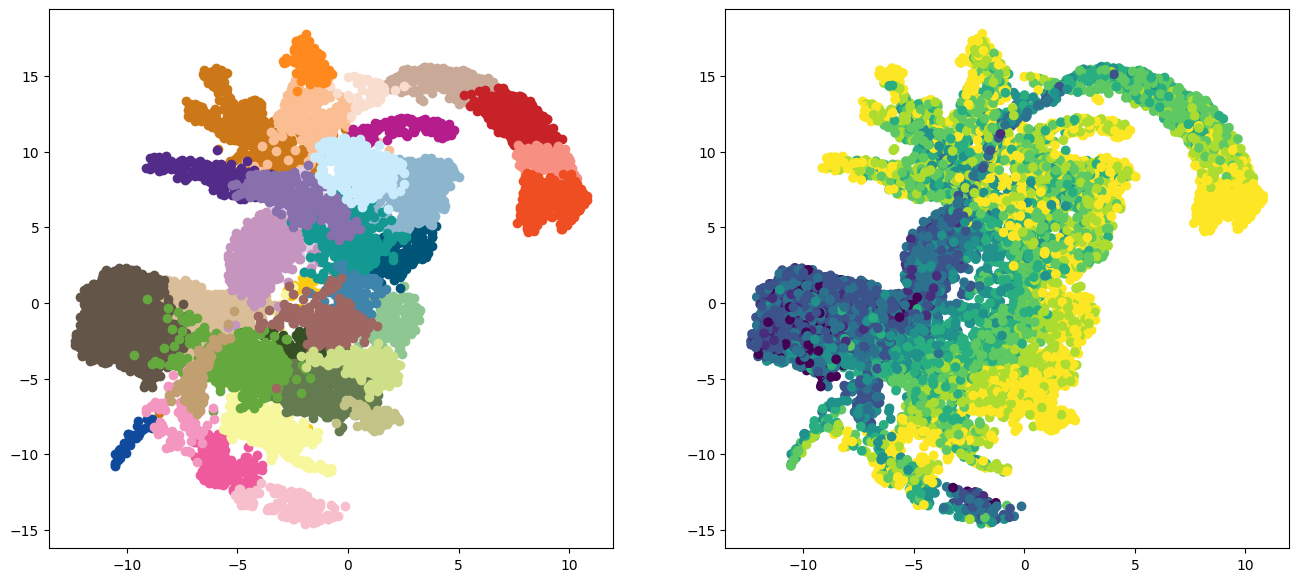

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
scat = ax[1].scatter(xdr.iloc[:,0], xdr.iloc[:,1], c=time)
for i in set(color):
    ax[0].scatter(xdr.iloc[color==i, 0], xdr.iloc[color==i,1], c=f'#{i}')
# cbar = plt.colorbar(scat)

In [12]:
sd.normalize_filter(is_normalize=False, is_log=False, min_count=20, target_sum=None)

In [13]:
adata = ad.AnnData(sd.count)
sc.pp.filter_genes(adata, min_counts=100)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sd.x_normed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

/home/wangkun/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
megs = pd.read_csv('../megs/lt_megs.csv', index_col=0)
vels = []
for i in sd.x_normed.columns:
    if i in megs.index:
        vels.append(megs['1'][i])
    else:
        vels.append(0)
vels = np.array(vels)

In [19]:
sd.velocity = vels

In [22]:
pv.velocity_embedding(sd, target='x_normed', n_neigh=800)

  0%|          | 0/10000 [00:00<?, ?it/s]

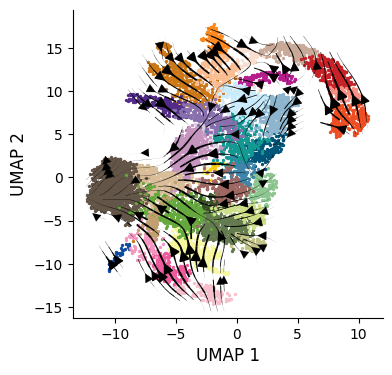

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
# ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:,1], c=time, s=2)
for i in set(color):
    ax.scatter(sd.Xdr.iloc[color==i, 0], sd.Xdr.iloc[color==i,1], c=f'#{i}', s=2)
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.6, grid_density=25, radius=0.5, lw_coef=40000, arrowsize=1.5)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)

# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [777]:
pv.calc_phylo_pseudotime(sd, r_sample=0.06, n_neighbors=100)

  0%|          | 0/599 [00:00<?, ?it/s]

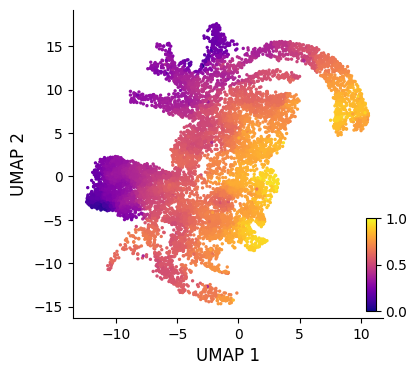

In [779]:
fig, ax = plt.subplots(figsize=(4, 4))
# ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:,1], c=time, s=2)
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:,1], c=sd.phylo_pseudotime, s=2, cmap='plasma')
# ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.6, grid_density=25, radius=0.5, lw_coef=40000, arrowsize=1.5)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)

cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

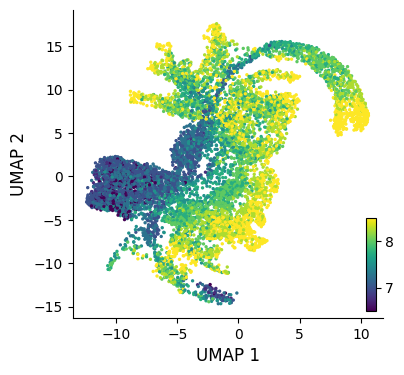

In [780]:
fig, ax = plt.subplots(figsize=(4, 4))
# ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:,1], c=time, s=2)
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:,1], c=time, s=2)
# ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.6, grid_density=25, radius=0.5, lw_coef=40000, arrowsize=1.5)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)

cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)